In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
import itertools
import dask
import dask.dataframe as dd 

sys.path.append('/projects/dedu0223/spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow


In [2]:
def add_s1_depths(row):
    c = row.C
    #print(f'    {c}')
    
    ds = calc_snow_index_to_snow_depth(dsB, C=c, inplace=False)
    rmse_wet, rmse = get_rmse(ds, closest_ts)
    return rmse_wet, rmse

def get_rmse(ds, closest_ts):
    mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                        ds['wet_snow'].sel(time=closest_ts).astype(bool))
    diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
    rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))

    
                # Compare snow depths - no wet snow mask
    mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
    diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
    rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
    
    return rmse_wet, rmse

def change_b(ds, b):
    ds = calc_delta_gamma(dsA, B=b, inplace=False)
    ds = clip_delta_gamma_outlier(ds)
    ds = calc_snow_index(ds)
    ds = id_newly_wet_snow(ds)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds)
    ds = flag_wet_snow(ds)
    return ds

In [3]:
# %%time
files = sorted(glob('/projects/dedu0223/snow_ex_data/*.nc'))

for f in files[8:]:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')
    
    ds_ = xr.open_dataset(f).load() # Open dataset 

    
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    #dataset = dataset.where((dataset.fcf>0.75))# & (dataset.fcf>0.25))
    
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays

2023-04-17 11:17:53.986381  -- starting /projects/dedu0223/snow_ex_data/Mores_2021-03-15


In [4]:
A = np.arange(1, 1.1, 0.5)
B = np.arange(0, 1, 0.1)
C = np.arange(0, 2, 0.1)

dataset_lowf = dataset.where((dataset.fcf<0.25))
dataset_midf = dataset.where((dataset.fcf<0.75) & (dataset.fcf>0.25))
dataset_highf = dataset.where((dataset.fcf>0.75))

all_datasets = [dataset_lowf, dataset_midf, dataset_highf, dataset]
all_rmse_datasets = list()

for data in all_datasets:
    print('here')
    
    rmse_wet_flag = xr.DataArray(np.empty((len(A), len(B), len(C)))*np.nan,
                        coords=(A, B, C), dims=('A','B','C'))
    rmse_no_flag = xr.DataArray(np.empty((len(A), len(B), len(C)))*np.nan,
                            coords=(A, B, C), dims=('A','B','C'))
    
    for a in A:
        print(a)
        dsA = calc_delta_cross_ratio(data, A=a, inplace=False)
        for b in B:
            dsB = change_b(dsA, b)
            dfC = pd.DataFrame({'C':C})

            ddf = dd.from_pandas(dfC, npartitions=8)
            output_series = ddf.apply(add_s1_depths, axis=1, result_type='expand', meta=({0: float, 1: float}))
            output_series = output_series.compute()

            dfC['rmse_wet'] = output_series[0]
            dfC['rmse'] = output_series[1]

            for row in dfC.iterrows():
                rmse_wet_flag.loc[a, b, row[1].C] = row[1].rmse_wet
                rmse_no_flag.loc[a, b, row[1].C] = row[1].rmse
                
    all_rmse_datasets.append(rmse_wet_flag)

here
1.0
here
1.0
here
1.0
here
1.0


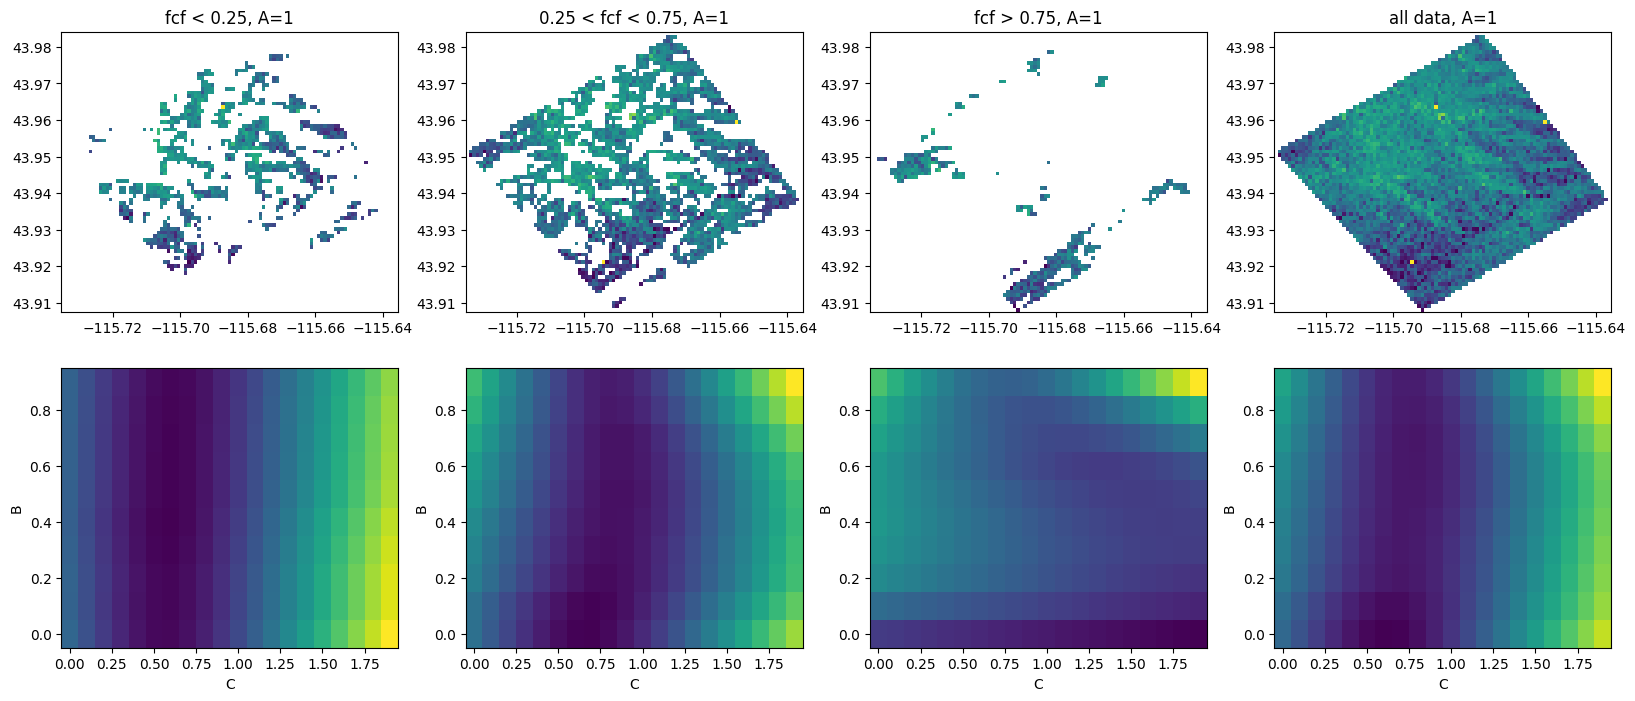

In [5]:
fig, ax = plt.subplots(2,4, figsize = (20,8))
titles = ['fcf < 0.25, A=1', '0.25 < fcf < 0.75, A=1', 'fcf > 0.75, A=1', 'all data, A=1']

for i in range(len(all_rmse_datasets)):
    d1 = all_datasets[i]
    ax[0,i].pcolormesh(d1.x, d1.y, d1['lidar-sd'], vmin = 0, vmax = 4)
    ax[0,i].set_title(titles[i])
    
    d = all_rmse_datasets[i].sel(A=1)
    ax[1,i].pcolormesh(d.C, d.B, d)
    ax[1,i].set_xlabel('C')
    ax[1,i].set_ylabel('B')

